# Floods Damage Detection with Satellite Images

### Convolutional Neural Network Model

*Author*: Margarita Popova

*Contact*: margeorita@gmail.com 

*Date*: 12/10/2022


*Notebook:* 2 of 2

## Table Of Contents

 [Introduction](#Introduction)

1. [Wrangling Image Dataset](#Wrangling-Image-Dataset)
 - [Exploring Images with Damage](#Exploring-Images-with-Damage)
 - [Exploring Images without Damage](#Exploring-Images-without-Damage)
2. [Creating the Tabular Dataset](#Creating-the-Tabular-Dataset)
 - [Preparing the Subset of Data Points with Damage](#Preparing-the-Subset-of-Data-Points-with-Damage)
 - [Preparing the Subset of Data Points without Damage](#Preparing-the-Subset-of-Data-Points-without-Damage)
3. [Load Data using a Keras Utility](#Load-Data-using-a-Keras-Utility)
4. [Build a Model](#Build-a-Model)
5. [Visualizing Representations of Activations of CNN layers](#Visualizing-Representations-of-Activations-of-CNN-layers)
6. [Data Augmentation](#Data-Augmentation)
7. [Predictions](#Predictions)
7. [Predictions with New images, which the Model has not Seen](#Predictions-with-New-images,-which-the-Model-has-not-Seen)
 - [Predictions of Damage](#Predictions-of-Damage)
 - [Predictions of No Damage](#Predictions-of-No-Damage)

[Conclusions](#Conclusions)

### Introduction

The following work includes analysis of a satellite imagery dataset with damage from Hurricane Harvey. Hurricane Harvey was a devastating Category 4 hurricane that made landfall on Texas and Louisiana in August 2017, causing catastrophic flooding and more than 100 deaths, moreover about 204,000 houses were damaged.

The main aim of the work is to detect damages after hurricanes and floods on satellite images with machine learning techniques.
The analysis of satellite images allows us to cover a huge territory at once which is crucial for emergency monitoring and deep learning helps us to process this huge amount of data effectively.

### Wrangling Image Dataset

Import nessesary libraries.

In [1]:
#import basic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from statistics import mean, median

In [2]:
#import libraries for ML
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

#import libraries to open files from directory
import pathlib
from pathlib import Path

We will work with images in our dataset and first of all we should create variables with paths to images pathlib. The current notebook should be in the one folder with the dataset otherwise you also may write the full path to the folder `dataset`.

In [3]:
#define directory as path to folder 'dataset'
directory = Path('dataset')

Let's check how many images are in the dataset.

In [4]:
#count images in dataset with modile glob
image_count = len(list(directory.glob('*/*.jpeg'))) #count all files with extension .jpeg
print(f'The dataset contans {image_count} images.')

The dataset contans 21057 images.


With glob we also may check the name of subfolders in the main folder `dataset` which correspond to classes of images.

In [5]:
#classes of images
list(directory.glob('**/'))

[WindowsPath('dataset'),
 WindowsPath('dataset/damage'),
 WindowsPath('dataset/no_damage')]

Let's count the number of images with damage:

In [6]:
#count images with damage
damage_count = len(list(directory.glob('damage/*.jpeg')))
print(f'The subset "damage" contains  {damage_count} images.')

The subset "damage" contains  14021 images.


In [7]:
#count images without damage
no_damage_count = len(list(directory.glob('no_damage/*.jpeg')))
print(f'The subset "damage" contains  {no_damage_count} images.')

The subset "damage" contains  7036 images.


The easiest way to evaluate class ratio in the dataset is visualization, so let's create a small dataset with image counts and build a plot.

In [8]:
#make a little dataframe to visualize counts
df = pd.DataFrame([no_damage_count, damage_count], index = ['no_damage', 'damage'], columns = ['mark_damage'])
df.head()

,mark_damage
no_damage,7036
damage,14021


In [9]:
#count the ratio of classes
df['mark_damage_prc'] = round(df['mark_damage']/df['mark_damage'].sum()*100, 2) #count percentage of each class and round it
df.head()

,mark_damage,mark_damage_prc
no_damage,7036,33.41
damage,14021,66.59


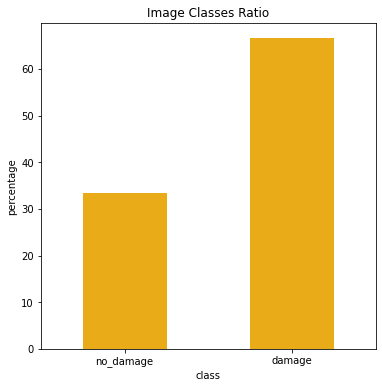

In [10]:
#plot the image classes ratio
plt.figure(figsize=(6,6))
df['mark_damage_prc'].plot(kind='bar', color = '#E9AB17')
plt.xticks(rotation = 0)
plt.xlabel('class')
plt.ylabel('percentage')
plt.title('Image Classes Ratio')
plt.show()

We have 66% of images with damage and 34% images without damages.

Let's check some images in our dataset.

#### Exploring Images with Damage

First, let's look at the images with damage.

To open an image in the notebook we will use PIL.

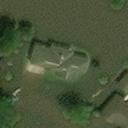

In [11]:
#define the path to images with damage
damage = list(directory.glob('damage/*'))
#open image with PIL
PIL.Image.open(damage[900]) #set any index from 1 to 14020


Most of the images show houses surrounded by water, but there are also a few ruined houses and fallen structures.

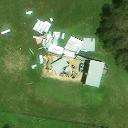

In [12]:
#example of a ruined building
PIL.Image.open(damage[14001])

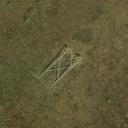

In [13]:
#example of a fallen structure
PIL.Image.open(damage[14008])

We can check the distribution of average values of every channel of the images and then compare with the same values gained from images without damages.

There is long-running code, so the results was saved as csv file. You also can run code with smaller range and get a quite similar result.

In [20]:
#extract mean values of every channel of images
list_damage = []
#start loop through the all images in the folder
for i in range(1,14021): #take not all values to reduсe processing time (take 2000)
    rgb_list = []
    #start loop through the channels in the image
    for band in range(3): #we are take all 3 channels - RGB
        avg = mean(PIL.Image.open(damage[i]).getdata(band))
        rgb_list.append(avg)
    list_damage.append(rgb_list)

For further visualisation we add the results of mean values of channels analysis in the dataframe.

In [21]:
#add list of mean values in dataframe
damage_rgb_df = pd.DataFrame(list_damage, columns = ['Red', 'Green', 'Blue'])

In [22]:
#save result as csv-file
damage_rgb_df.to_csv('damage_rgb_df.csv')

You can use the prepared CSV from the attachment uncommenting the second string in the cell below. If you have run the loop above by yourself, just ignore the cell below.

In [14]:
#open csv
#damage_rgb_df = pd.read_csv('damage_rgb_df.csv')

Let's count the mean and median values of every channel throughout all images in the subfolder `damage`

In [15]:
#mean and median values for R chanel
damage_rgb_df['Red'].mean(), damage_rgb_df['Red'].median()

(88.26641387721781, 84.100830078125)

In [16]:
#mean and median values for G chanel
damage_rgb_df['Green'].mean(), damage_rgb_df['Green'].median()

(95.50440176230525, 92.3790283203125)

In [17]:
#mean and median values for B chanel
damage_rgb_df['Blue'].mean(), damage_rgb_df['Blue'].median()

(70.63166478656328, 67.81179809570312)

Finally, let's plot the distribution of each channel value for images with damage.

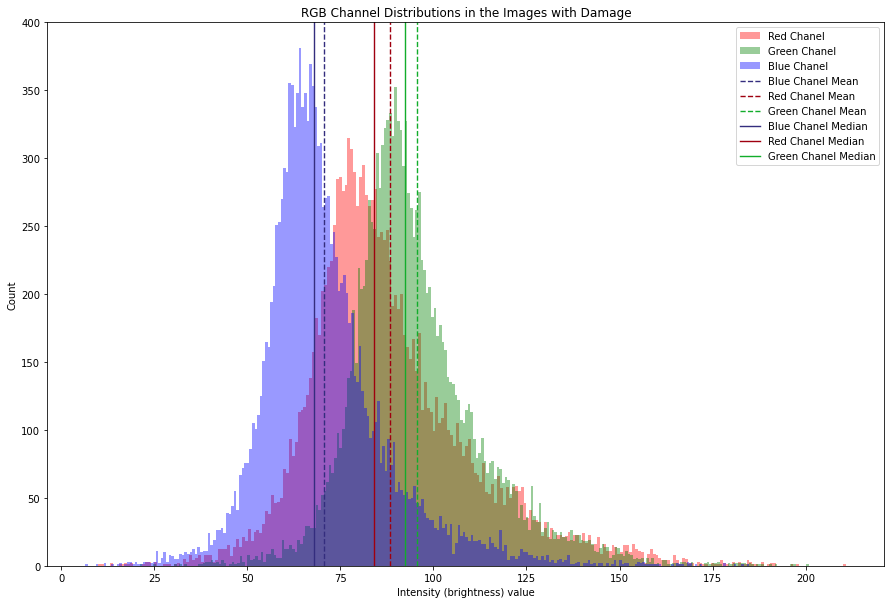

In [22]:
#plot results
plt.figure(figsize=(15,10))

#build histogram for every chanel
plt.hist(damage_rgb_df['Red'], label = "Red Chanel", color='red', bins=255, alpha=0.4) #number of bins from 0 to 255
plt.hist(damage_rgb_df['Green'], label = "Green Chanel", color = 'green', bins=255, alpha=0.4)
plt.hist(damage_rgb_df['Blue'], label = "Blue Chanel", color = 'blue', bins=255, alpha=0.4)

#mark mean
plt.axvline(damage_rgb_df['Blue'].mean(), color='#342D7E', linestyle='dashed', linewidth=1.4, label = "Blue Chanel Mean")
plt.axvline(damage_rgb_df['Red'].mean(), color='#9F000F', linestyle='dashed', linewidth=1.4, label = "Red Chanel Mean")
plt.axvline(damage_rgb_df['Green'].mean(), color='#12AD2B', linestyle='dashed', linewidth=1.4, label = "Green Chanel Mean")
#mark median
plt.axvline(damage_rgb_df['Blue'].median(), color='#342D7E', linewidth=1.4, label = "Blue Chanel Median")
plt.axvline(damage_rgb_df['Red'].median(), color='#9F000F', linewidth=1.4, label = "Red Chanel Median")
plt.axvline(damage_rgb_df['Green'].median(), color='#12AD2B', linewidth=1.4, label = "Green Chanel Median")

#labels
plt.xlabel('Intensity (brightness) value')
plt.ylabel('Count')
plt.title('RGB Channel Distributions in the Images with Damage')
plt.legend()

plt.show()

### Exploring Images without Damage

Now the same features we will estimate for images without damages.


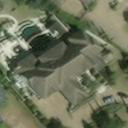

In [25]:
#define the path to images with damage
no_damage = list(directory.glob('no_damage/*'))
#open image with PIL
PIL.Image.open(no_damage[1001]) #sat any index from 1 to 7035

Note the images without damage may include houses which are located really close to the quay and that may be the reason for future model confusion. The main challenge here is that we try to detect not a single object or even group of objects, we try to detect the specific situation.

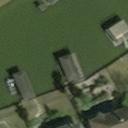

In [26]:
#example of houses on the quay
PIL.Image.open(no_damage[900])

There is long-running code too, so the results was saved as csv file.

In [32]:
#extract mean values of every chanel of images
list_no_damage = []
for i in range(1,7035): #take not all values to reduсe processing time (take 1000)
    rgb_list_no_damage = []
    for band in range(3):
        avg_no_damage = mean(PIL.Image.open(no_damage[i]).getdata(band))
        rgb_list_no_damage.append(avg_no_damage)
    list_no_damage.append(rgb_list_no_damage)

In [34]:
#add list of mean values in dataframe
no_damage_rgb_df = pd.DataFrame(list_no_damage, columns = ['Red', 'Green', 'Blue'])

In [35]:
no_damage_rgb_df.to_csv('no_damage_rgb_df.csv')

You can use the prepared CSV from the attachment uncommenting the second string in the cell below. If you have run the loop above by yourself, just ignore the cell below.

In [27]:
#open csv
#no_damage_rgb_df = pd.read_csv('no_damage_rgb_df.csv')

Let's count the mean and median values of every channel throughout all images in the subfolder `no_damage`

In [36]:
#mean and median values for R chanel
no_damage_rgb_df['Red'].mean(), no_damage_rgb_df['Red'].median()

(92.91929934937947, 89.77056884765625)

In [37]:
#mean and median values for G chanel
no_damage_rgb_df['Green'].mean(), no_damage_rgb_df['Green'].median()

(102.65326190652378, 99.53201293945312)

In [38]:
#mean and median values for B chanel
no_damage_rgb_df['Blue'].mean(), no_damage_rgb_df['Blue'].median()

(77.08193429139381, 74.07659912109375)

Let's plot the distribution of each channel value for images without damage.

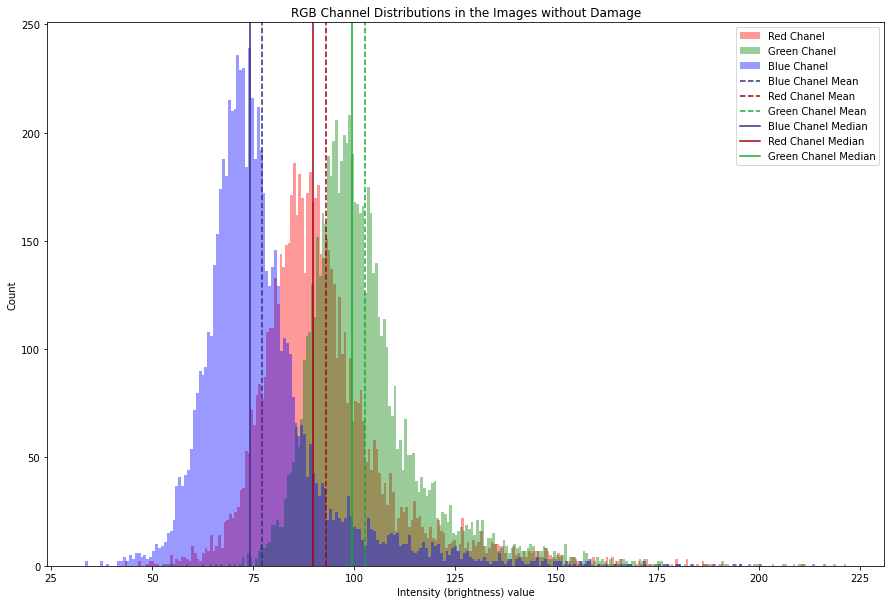

In [39]:
#plot the results
plt.figure(figsize=(15,10))

plt.hist(no_damage_rgb_df['Red'], label = "Red Chanel", color='red', bins=255, alpha=0.4)
plt.hist(no_damage_rgb_df['Green'], label = "Green Chanel", color = 'green', bins=255, alpha=0.4)
plt.hist(no_damage_rgb_df['Blue'], label = "Blue Chanel", color = 'blue', bins=255, alpha=0.4)

plt.axvline(no_damage_rgb_df['Blue'].mean(), color='#342D7E', linestyle='dashed', linewidth=1.5,label = "Blue Chanel Mean")
plt.axvline(no_damage_rgb_df['Red'].mean(), color='#9F000F', linestyle='dashed', linewidth=1.5,label = "Red Chanel Mean")
plt.axvline(no_damage_rgb_df['Green'].mean(), color='#12AD2B', linestyle='dashed', linewidth=1.5,label = "Green Chanel Mean")

plt.axvline(no_damage_rgb_df['Blue'].median(), color='#342D7E', linewidth=1.5,label = "Blue Chanel Median")
plt.axvline(no_damage_rgb_df['Red'].median(), color='#9F000F', linewidth=1.5,label = "Red Chanel Median")
plt.axvline(no_damage_rgb_df['Green'].median(), color='#12AD2B', linewidth=1.5,label = "Green Chanel Median")

plt.xlabel('Intensity (brightness) value')
plt.ylabel('Count')
plt.title('RGB Channel Distributions in the Images without Damage')

plt.legend()
plt.show()

The Blue and Green channels are distributed differently in the images with damages and without which is a curious diagnostic feature for analysis. 

Moreover, the average values of intensity of every channel are different: images with damage have lower values, which is mean that images with damage a little bit darker or have higher contrast.

### Load Data using a Keras Utility

To analyze data we will use a supervised deep learning model using Keras - library to build the neural networks. For image classification to finde images with damage we will use convolutional neural network (CNN). CNNs are a special type of network primarily used for image recognition.

First, we are loading images off local disk using the `tf.keras.utils.image_dataset_from_directory` utility.

Some important parameters for creating dataset for CNN:
   * batch_size = 32. Batch size is the number of training examples utilized in one iteration;
   * img_height = 128. The default size in the dataset;
   * img_width = 128. The default size in the dataset.

These parameters will be used to create train and validation subsets.

We should split the original dataset to get the training and validation datasets. We use 80% of the images for training and 20% for validation.

In [40]:
#create train set
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    color_mode='rgb',
    image_size=(128, 128),
    batch_size = 32,
    validation_split=0.2,
    subset="training",
    seed=123,
    interpolation='bilinear')

Found 21057 files belonging to 2 classes.
Using 16846 files for training.


Also, split to get dataset for validation

In [41]:
#create test set
valid_ds = tf.keras.utils.image_dataset_from_directory(
  directory,
  color_mode='rgb',
  image_size=(128, 128),
  batch_size = 32,
  validation_split=0.2,
  subset="validation",
  seed=123)

Found 21057 files belonging to 2 classes.
Using 4211 files for validation.


The model will be trained by batches of images, every batch includes several images. The most common batch sizes are 10 and 32, we will use 32.

In [42]:
#display class names
class_names = train_ds.class_names
print(class_names)

print(f'The number of batches in training set: {len(train_ds)}, it is means 16846 images divided into batches with 32 in each batch: {16846/32} '), 
print(f'The number of batches in validation set:{len(valid_ds)}, 4211 images images divided into batches with 32 in each batch: {4211/32}')

['damage', 'no_damage']
The number of batches in training set: 527, it is means 16846 images divided into batches with 32 in each batch: 526.4375 
The number of batches in validation set:132, 4211 images images divided into batches with 32 in each batch: 131.59375


To make sure that we managed to create a training subset with images let's display some random images.

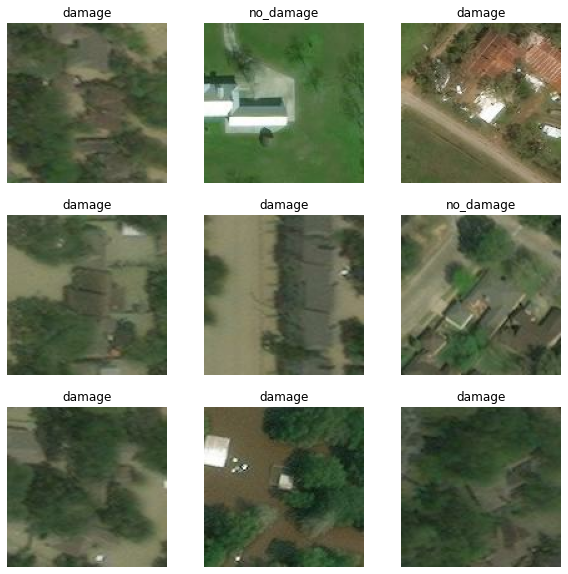

In [35]:
#display some examples of images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Build a Model

The rocess of building the model includes the next stages:
 - Optimize performance if necessary
 - Build a model using different hidden layers
 - Compile a model
 - Train a model
 - Estimate accuracy

In [ ]:
#optimize model performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

`Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache. `Dataset.prefetch` overlaps data preprocessing and model execution while training.

**Build** a model which is include 16 hidden layers.

In [43]:
num_classes = len(class_names) #2 - damage and no_damage

#create a new sequential model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)), #input rescaled image
  layers.Conv2D(filters=16, kernel_size = 3, padding='same', activation='relu'), #first convolutional layer
  layers.MaxPooling2D(pool_size=2, padding='valid'), #first pooling layer
    
  layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2, padding='valid'),
  layers.Dropout(0.2), #dropout of some nodes
    
  layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2, padding='valid'),
  layers.Dropout(0.2),

  layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2, padding='valid'),
  layers.Dropout(0.2), 
    
  layers.Flatten(), # llatten the output of the convolutional layers
  layers.Dense(128, activation='relu'), #first dense layers
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax') #output layer
])

The next step is **compiling** the model with optimizer 'adam'.

The model may train for a long time, so let's add early stopping. Early stopping will stop the training process once the model no longer has improvements in our validation loss.

In [44]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#add early stopping
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)

The model summary describes the parameters of each layer of the model. Let's display it.

In [45]:
#get model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0

For the visualization of the model architecture, we can use the special package `visualkeras`.

In [46]:
import visualkeras

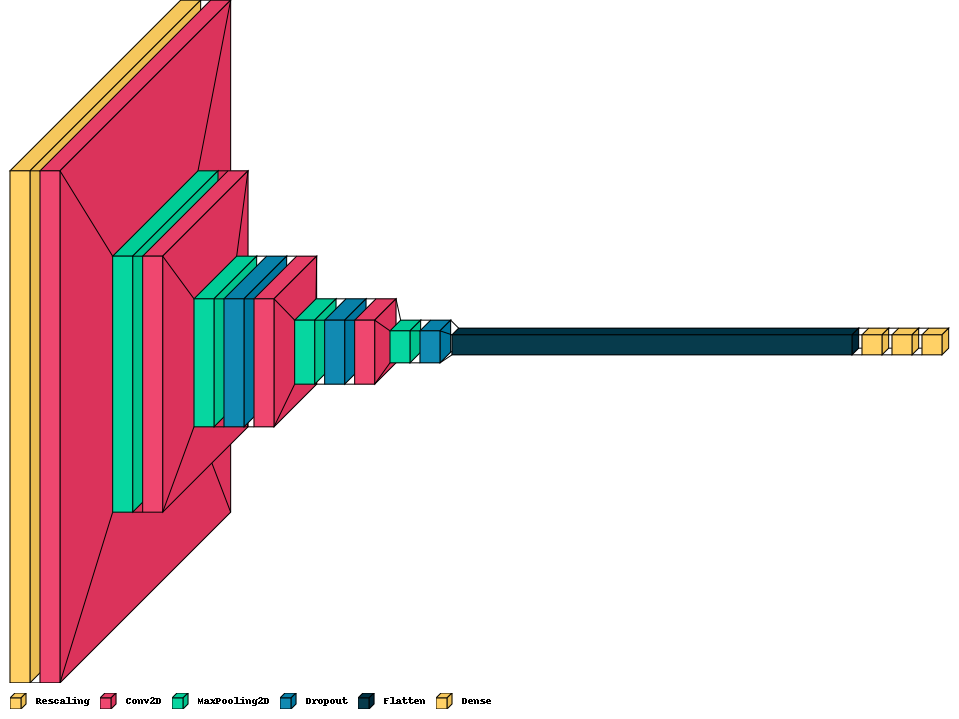

In [47]:
visualkeras.layered_view(model,legend=True, draw_volume=True, to_file='architecture.png')

The network includes 16 layers and 1,154,530 trainable weights.

Finally we can **train** our model. Set the number of epochs to 20 - it is not much to avoid overfitting and on the other hand, it is not a little to avoid underfitting.

Warning! Each epoch is processing about 80 seconds.

In [40]:
#train model
epochs=20
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs, 
  callbacks=[early_stop]
)

Epoch 1/20


C:\Users\marge\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


527/527 [==============================] - 88s 158ms/step - loss: 0.3883 - accuracy: 0.8246 - val_loss: 0.2904 - val_accuracy: 0.8770
Epoch 2/20
527/527 [==============================] - 82s 156ms/step - loss: 0.1710 - accuracy: 0.9344 - val_loss: 0.1701 - val_accuracy: 0.9314
Epoch 3/20
527/527 [==============================] - 84s 159ms/step - loss: 0.1258 - accuracy: 0.9529 - val_loss: 0.1512 - val_accuracy: 0.9373
Epoch 4/20
527/527 [==============================] - 82s 156ms/step - loss: 0.1112 - accuracy: 0.9566 - val_loss: 0.1218 - val_accuracy: 0.9549
Epoch 5/20
527/527 [==============================] - 81s 155ms/step - loss: 0.0950 - accuracy: 0.9640 - val_loss: 0.1048 - val_accuracy: 0.9606
Epoch 6/20
527/527 [==============================] - 82s 156ms/step - loss: 0.0868 - accuracy: 0.9666 - val_loss: 0.0714 - val_accuracy: 0.9706
Epoch 7/20
527/527 [==============================] - 82s 156ms/step - loss: 0.0823 - accuracy: 0.9685 - val_loss: 0.1097 - val_accuracy: 0.9

Let's estimate the accuracy and score of our model.

In [42]:
#score the final accuracy
score = model.evaluate(valid_ds, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

132/132 [==============================] - 5s 35ms/step - loss: 0.0690 - accuracy: 0.9736
Test loss: 0.06899949163198471
Test accuracy: 0.9736404418945312


The accuracy of the model is ~97%, the loss is 0.07. It is quite a decent result.


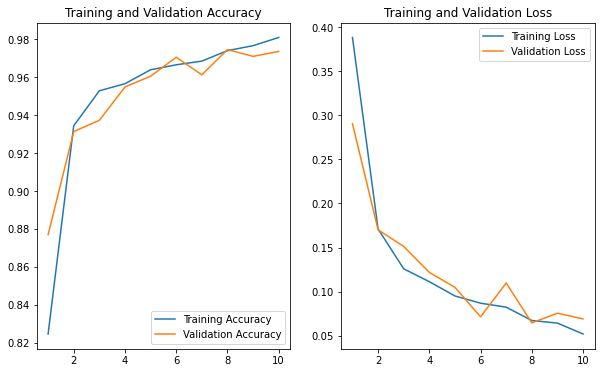

In [41]:
#plot the accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, 11) #range depend on early stopping. it is 'Epoch n: early stopping' + 1 from the train log

#plot accuracy
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('accuracy.png')

plt.show()

The curve of validation accuracy is very close to the curve of training score but we have a big chance of overfitting with such a complex model.

### Visualizing Representations of Activations of CNN layers


To understand how convolutional neural networks learn dependencies of an image, different features captured at each layer can be visualized.

To visualize the features at each layer, Keras Model class is used. 
It allows the model to have multiple outputs.
It maps given a list of input tensors to list of output tensors.

In [49]:
#import models and utils
from keras import models
import keras.utils as utils

Let's open any damage from folder `damage` and pre-process it with `keras.utils`.

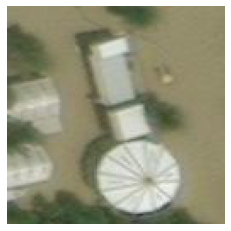

In [142]:
#pre-processing the image
img = PIL.Image.open(f'{directory}/damage/-95.664918_29.820815999999997.jpeg') #open any image
#turn image to array
img_tensor = utils.img_to_array(img)
#expand the shape of an array
img_tensor = np.expand_dims(img_tensor, axis = 0)
#convert RGB pixel values to [0.0, 1.0] range
img_tensor = img_tensor / 255.
 
#print image
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

From the model summary, we know that our network consists of 16 layers with 4 convolutional layers. Let's output the shape of the first convolution layer.

In [143]:
#outputs of the 16 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:16]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)
  
#getting Activations of first convolutional layer
layer_activation = activations[1] #here is 0-based indexing, so the index of convolutional layer 1 (the first layer is rescaling)
# shape of first layer activation
print(layer_activation.shape)

1/1 [==============================] - 0s 105ms/step
(1, 128, 128, 16)


First convolution layer includes 16 channels, let's output a couple of them.

(-0.5, 127.5, 127.5, -0.5)

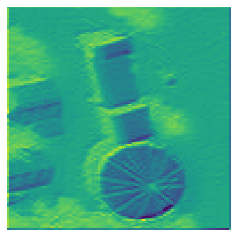

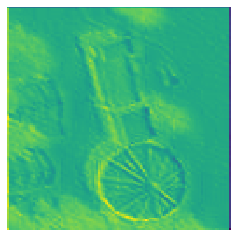

In [105]:
# 3th channel of the image after first layer of convolution is applied
plt.matshow(layer_activation[0, :, :, 3], cmap ='viridis')
plt.axis('off')  
# 12th channel of the image after first layer of convolution is applied
plt.matshow(layer_activation[0, :, :, 12], cmap ='viridis')
plt.axis('off')

We can also look at the outputs after other layers of convolution are applied.

Let's list the layers of the model to count the index of the next convolutional layer.

In [148]:
#list layers with for loop
layer_names=[]

for index, layer in enumerate(model.layers[:16]):
      layer_names.append(layer.name)
print(layer_names)

['rescaling', 'conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'dropout', 'conv2d_2', 'max_pooling2d_2', 'dropout_1', 'conv2d_3', 'max_pooling2d_3', 'dropout_2', 'flatten', 'dense', 'dense_1', 'dense_2']


The second convolutional layer has an index of 3.

In [149]:
# Getting Activations of the second convolution layer
layer_activation = activations[3] #set layer index
# shape of first layer activation
print(layer_activation.shape)

(1, 64, 64, 32)


The second convolutional layer has 32 channels. Let's plot the results.

(-0.5, 63.5, 63.5, -0.5)

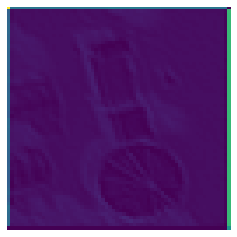

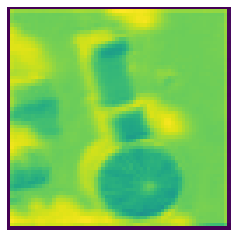

In [113]:
# 6th channel of the image after second layer of convolution is applied
plt.matshow(layer_activation[0, :, :, 6], cmap ='viridis')
plt.axis('off')  
# 17th channel of the image after second layer of convolution is applied
plt.matshow(layer_activation[0, :, :, 17], cmap ='viridis')
plt.axis('off')

Also, it is curious to look at the image after max_pooling is applied. Let's  display the image after second layer of max pooling is applied.

In [150]:
# Getting Activations of first layer
layer_activation = activations[4] #set layer index
# shape of first layer activation
print(layer_activation.shape)

(1, 32, 32, 32)


(-0.5, 31.5, 31.5, -0.5)

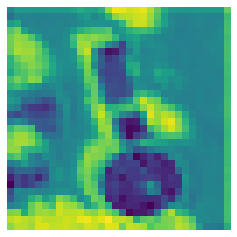

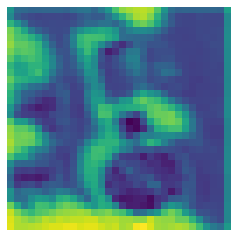

In [151]:
# 7th channel of the image after first layer of convolution is applied
plt.matshow(layer_activation[0, :, :, 7], cmap ='viridis')
plt.axis('off')  
# 29 th channel of the image after first layer of convolution is applied
plt.matshow(layer_activation[0, :, :, 29], cmap ='viridis')
plt.axis('off')

Also we can check image without damage.

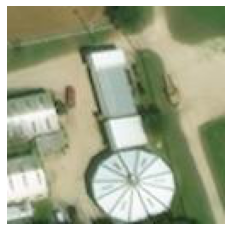

In [50]:
#pre-processing the image
img = PIL.Image.open(f'{directory}/no_damage/-95.664918_29.820815999999997.jpeg') #open any image
#turn image to array
img_tensor = utils.img_to_array(img)
#expand the shape of an array
img_tensor = np.expand_dims(img_tensor, axis = 0)
#convert RGB pixel values to [0.0, 1.0] range
img_tensor = img_tensor / 255.
 
#print image
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

In [51]:
#outputs of the 16 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:16]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)
  
#getting Activations of first convolutional layer
layer_activation = activations[1] #here is 0-based indexing, so the index of convolutional layer 1 (the first layer is rescaling)
# shape of first layer activation
print(layer_activation.shape)

1/1 [==============================] - 0s 230ms/step
(1, 128, 128, 16)


(-0.5, 127.5, 127.5, -0.5)

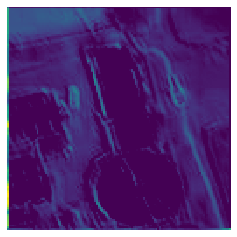

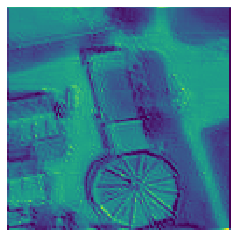

In [58]:
# 1st channel of the image after first layer of convolution is applied
plt.matshow(layer_activation[0, :, :, 1], cmap ='viridis')
plt.axis('off')  
# 15th channel of the image after first layer of convolution is applied
plt.matshow(layer_activation[0, :, :, 15], cmap ='viridis')
plt.axis('off')

Looking at the outputs after convolution, we can conclude that CNN is looking for lighter structures surrounded by darker backgrounds. In most of the images, houses are surrounded by dirty brown water and CNN is detecting it. Unfortunately, it is unclear if the CNN except for the contrast between buildings and background analyse also the shape of objects in the image.

Interestingly, the CNN is well handled with ruined buildings which are not in the water thanks to the fact that the pieces of ruined houses usually are very light because of constructing materials  - light drywall, wood, cinder blocks. And these light structures are surrounded by comparatively darker backgrounds too.

On the images without damage, CNN detected the edges of the buildings and a more complex background.

The weaknesses of the model:
- The model counts the shadows as the darker background too.
- The model may classify the image with a bright house in the middle of the plowed field as an image with damage with high probability
- Clouds and their shadows can also be classified as damage by the model, so only images without clouds should be used, which is sometimes not possible
    

### Data Augmentation

To avoid overfitting and increase the quality of training we can add some data augmentation. Data augmentation is a process of adding random flips, scaling, contrast and whatnot in the data.

Since we know that the contrast between objects on the image and colours are important diagnostic features but do not know the importance of the shape of the object we can try two kinds of augmentation:
- Adding randomness to the spectral parameters - Contrast and Brightness
- Adding shape modifications - Rotation, Scaling, Flipping

First, we try to estimate the model, trained by the images set with additional random brightness and contrast.

In [153]:
#define data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomBrightness(0.4),
    layers.RandomContrast(0.2),
  ]
)

We should add data augmentation as a new layer to the basic model.

In [154]:
#rebuild the model with augmentation
model_aug = Sequential([
  data_augmentation, #add data augmentation
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(filters=16, kernel_size = 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2, padding='valid'),
    
  layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2, padding='valid'),
  layers.Dropout(0.2),
    
  layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2, padding='valid'),
  layers.Dropout(0.2),

  layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2, padding='valid'),
  layers.Dropout(0.2), 
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

In [155]:
#compile the model
model_aug.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)

Warning! Each epoch is processing about 86 seconds.

In [156]:
#train
epochs=20
history = model_aug.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs, 
  callbacks=[early_stop]
)

Epoch 1/20


C:\Users\marge\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


527/527 [==============================] - 92s 167ms/step - loss: 0.4304 - accuracy: 0.7948 - val_loss: 0.2526 - val_accuracy: 0.8979
Epoch 2/20
527/527 [==============================] - 85s 162ms/step - loss: 0.2487 - accuracy: 0.8996 - val_loss: 0.2113 - val_accuracy: 0.9119
Epoch 3/20
527/527 [==============================] - 86s 163ms/step - loss: 0.2047 - accuracy: 0.9199 - val_loss: 0.1560 - val_accuracy: 0.9328
Epoch 4/20
527/527 [==============================] - 86s 163ms/step - loss: 0.1699 - accuracy: 0.9303 - val_loss: 0.1422 - val_accuracy: 0.9383
Epoch 5/20
527/527 [==============================] - 87s 165ms/step - loss: 0.1447 - accuracy: 0.9386 - val_loss: 0.1249 - val_accuracy: 0.9480
Epoch 6/20
527/527 [==============================] - 87s 166ms/step - loss: 0.1292 - accuracy: 0.9453 - val_loss: 0.1015 - val_accuracy: 0.9532
Epoch 7/20
527/527 [==============================] - 88s 166ms/step - loss: 0.1245 - accuracy: 0.9505 - val_loss: 0.0965 - val_accuracy: 0.9

In [157]:
#count the scores
score = model_aug.evaluate(valid_ds, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

132/132 [==============================] - 4s 33ms/step - loss: 0.1210 - accuracy: 0.9535
Test loss: 0.12097271531820297
Test accuracy: 0.9534552097320557


The accuracy is 95%. It is a little bit lower than the result without augmentation but still pretty high.

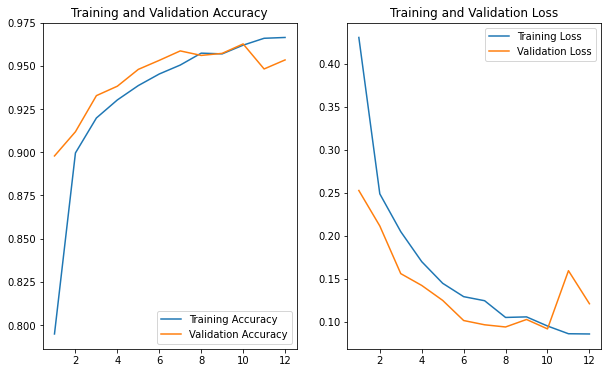

In [158]:
#plot results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, 13) #range depend on early stopping. it is (1, number epoch before early stopping + 1)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Now let's try to estimate the model, trained by the images set with additional random flip, rotation and zoom.

In [160]:
#try another kind of augmentation
data_augmentation_shape = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(128, 128, 3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2)
  ]
)

In [161]:
#rebuild the model with augmentation
model_aug_shape = Sequential([
  data_augmentation_shape,
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(filters=16, kernel_size = 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2, padding='valid'),
    
  layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2, padding='valid'),
  layers.Dropout(0.2),
    
  layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2, padding='valid'),
  layers.Dropout(0.2),

  layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2, padding='valid'),
  layers.Dropout(0.2), 
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

In [162]:
#compile the model
model_aug_shape.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)

Warning! Each epoch is processing about 97 seconds.

In [163]:
#train
epochs=20
history = model_aug_shape.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs, 
  callbacks=[early_stop]
)

Epoch 1/20
527/527 [==============================] - 101s 184ms/step - loss: 0.5583 - accuracy: 0.7171 - val_loss: 0.3586 - val_accuracy: 0.8485
Epoch 2/20
527/527 [==============================] - 96s 183ms/step - loss: 0.2677 - accuracy: 0.8926 - val_loss: 0.2422 - val_accuracy: 0.9043
Epoch 3/20
527/527 [==============================] - 97s 184ms/step - loss: 0.2031 - accuracy: 0.9256 - val_loss: 0.3548 - val_accuracy: 0.8492
Epoch 4/20
527/527 [==============================] - 98s 185ms/step - loss: 0.1804 - accuracy: 0.9314 - val_loss: 0.2333 - val_accuracy: 0.9090
Epoch 5/20
527/527 [==============================] - 96s 183ms/step - loss: 0.1657 - accuracy: 0.9365 - val_loss: 0.2928 - val_accuracy: 0.8725
Epoch 6/20
527/527 [==============================] - 95s 181ms/step - loss: 0.1514 - accuracy: 0.9418 - val_loss: 0.2539 - val_accuracy: 0.9064
Epoch 6: early stopping


In [165]:
#count the scores
score = model_aug_shape.evaluate(valid_ds, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

132/132 [==============================] - 5s 35ms/step - loss: 0.2539 - accuracy: 0.9064
Test loss: 0.2539166808128357
Test accuracy: 0.9064355492591858


With shape augmentation, the results are much lower - ~91%, which shows the model uses the specific shape of the object and their position on the image as diagnostic feature.

### Predictions

For predictions, we will use the model with the highest accuracy - the basic model without augmentation.

We can choose randomly the image from our dataset and check which class will predicl our model.

In [166]:
# Select any image from folder 'damage':
img = PIL.Image.open(f'{directory}/damage/-95.086831_29.829598999999998.jpeg')

(-0.5, 127.5, 127.5, -0.5)

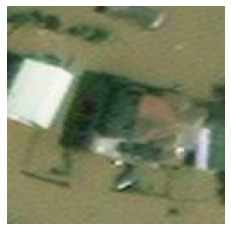

In [167]:
# Let's look how image looks like
imgplot = plt.imshow(img)
plt.axis("off")

In [168]:
# turn the image into an array form which is what our model needs as an input. 
pred_img = tf.keras.preprocessing.image.img_to_array(img, data_format=None, dtype=None)

In [169]:
# Run the prediction with our model
prediction = model.predict(pred_img.reshape(1,128,128,3)) # reshape for 4D as tensorflow expects

print("Target class percentage probabilities: Damage(0), No_Damage(1)")
np.round(prediction, 3)*100   # rounding and expressing as percentage probabilities of each class

1/1 [==============================] - 0s 88ms/step
Target class percentage probabilities: Damage(0), No_Damage(1)


array([[85.799995, 14.200001]], dtype=float32)

The model predicted that there is damage on the image with a probability of 85,8% and that is correct.

Now let's test the model with random image in the folder `no_damage`

(-0.5, 127.5, 127.5, -0.5)

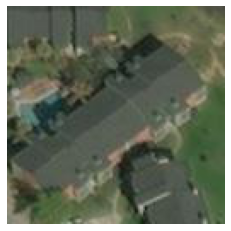

In [171]:
# Select any image from folder 'no_damage'
img2 = PIL.Image.open(f'{directory}/no_damage/-95.642881_29.862401000000002.jpeg')
#display the image
imgplot = plt.imshow(img2)
plt.axis("off")

In [172]:
# turn the image into an array form which is what our model needs as an input. 
pred_img2 = tf.keras.preprocessing.image.img_to_array(
    img2, data_format=None, dtype=None)

In [173]:
# Run the prediction with our food model! 
prediction = model.predict(pred_img2.reshape(1,128,128,3)) # Reshape for 4D as tensorflow expects

print("Target class percentage probabilities: Damage(0), No_Damage(1)")
np.round(prediction,4)*100   # rounding and expressing as percentage probabilities of each class

1/1 [==============================] - 0s 17ms/step
Target class percentage probabilities: Damage(0), No_Damage(1)


array([[  0., 100.]], dtype=float32)

The model predicted that there is no damage on the image with a probability of 100% and that is correct

Looks like the model works well with the dataset which was used for training and validation.

### Predictions with New images, which the Model has not Seen

#### Predictions of Damage

Now let's try something really exciting. We will open and analyze an image from a different dataset. This dataset came from https://disasterresponse.maps.arcgis.com/apps/StorytellingSwipe/index.html?appid=2e499ec7eb784237bd70fb16ae0f5dcf# - the Louisiana Swipe Map powered by ESRI with images provided by NOAA. The images in the png format.

In [174]:
#define the path to the images
path = Path('predictions_set')

(-0.5, 511.5, 359.5, -0.5)

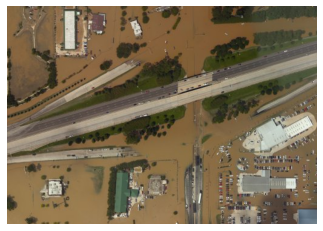

In [175]:
# Select your image by providing the relative path:
img_new = PIL.Image.open(f'{path}/damage/6010_1.png')
imgplot = plt.imshow(img_new)
plt.axis("off")

The image have shape 512x360 pixels and we need to reshape it, because our model works with 128x128 images.

In [176]:
#reshape image
res = img_new.resize((128, 128))

In [177]:
#pre-process
pred_img_new = tf.keras.preprocessing.image.img_to_array(
    res, data_format=None, dtype=None)

In [178]:
# Run the prediction with our model 
prediction = model.predict(pred_img_new.reshape(1,128,128,3)) # Reshape for 4D as tensorflow expects

print("Target class percentage probabilities: Damage(0), No_Damage(1)")
np.round(prediction,4)*100

1/1 [==============================] - 0s 22ms/step
Target class percentage probabilities: Damage(0), No_Damage(1)


array([[99.54,  0.46]], dtype=float32)

The model predicted that there is damage on the image with a probability of 99.5% and that is correct.

Let's write the function to make the predictions easier and check some more images.

In [179]:
def predict_damage(image):
    """
    The function takes an image and reshapes it. 
    Then function makes a prediction using our main model and return the results as a list of probabilities for each class
    """
    reshape = image.resize((128, 128))
    pred_image = tf.keras.preprocessing.image.img_to_array(reshape, data_format=None, dtype=None)
    prediction = model.predict(pred_image.reshape(1,128,128,3))
    print("Target class percentage probabilities: Damage(0), No_Damage(1)")
    print(np.round(prediction,4)*100)

(-0.5, 511.5, 359.5, -0.5)

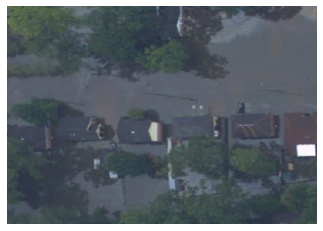

In [198]:
# Select an image
img_new2 = PIL.Image.open(f'{path}/damage/1001_1.png')
imgplot = plt.imshow(img_new2)
plt.axis("off")

In [199]:
#make prediction
predict_damage(img_new2)

1/1 [==============================] - 0s 17ms/step
Target class percentage probabilities: Damage(0), No_Damage(1)
[[16.09 83.91]]


The model predicted that there is damage on the image and that is correct.

(-0.5, 511.5, 359.5, -0.5)

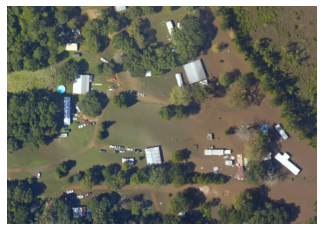

In [182]:
# Select your image by providing the relative path:
img_new3 = PIL.Image.open(f'{path}/damage/17000_1.png')
imgplot = plt.imshow(img_new3)
plt.axis("off")

In [183]:
#make prediction
predict_damage(img_new3)

1/1 [==============================] - 0s 18ms/step
Target class percentage probabilities: Damage(0), No_Damage(1)
[[ 0.12 99.88]]


The model made a mistake with this image because the boundary between the water and the field is completely fuzzy.

(-0.5, 511.5, 359.5, -0.5)

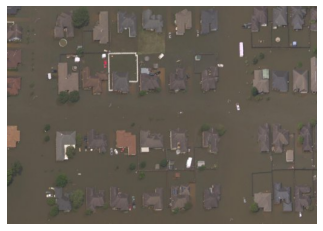

In [184]:
# Select your image by providing the relative path:
img_new4 = PIL.Image.open(f'{path}/damage/4000_1.png')
imgplot = plt.imshow(img_new4)
plt.axis("off")

In [185]:
predict_damage(img_new4)

1/1 [==============================] - 0s 18ms/step
Target class percentage probabilities: Damage(0), No_Damage(1)
[[97.34       2.6599998]]


The model predicted that there is damage on the image and that is correct

(-0.5, 511.5, 359.5, -0.5)

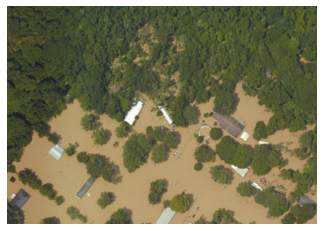

In [186]:
# Select your image by providing the relative path:
img_new5 = PIL.Image.open(f'{path}/damage/11007_1.png')
imgplot = plt.imshow(img_new5)
plt.axis("off")

In [187]:
predict_damage(img_new5)

1/1 [==============================] - 0s 18ms/step
Target class percentage probabilities: Damage(0), No_Damage(1)
[[100.   0.]]


The model predicted that there is damage on the image and that is correct too.

#### Predictions of No Damage

(-0.5, 511.5, 359.5, -0.5)

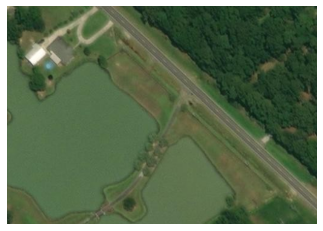

In [200]:
# Select your image by providing the relative path:
img_no_dam = PIL.Image.open(f'{path}/no_damage/9008.png')
imgplot = plt.imshow(img_no_dam)
plt.axis("off")

In [201]:
predict_damage(img_no_dam)

1/1 [==============================] - 0s 17ms/step
Target class percentage probabilities: Damage(0), No_Damage(1)
[[83.54 16.46]]


The model predicted that there is damage on the image and that is incorrect.

(-0.5, 511.5, 359.5, -0.5)

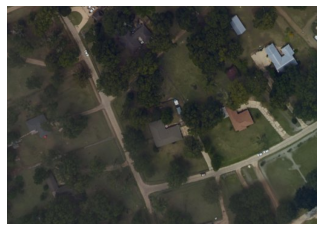

In [190]:
# Select your image by providing the relative path:
img_no_dam2 = PIL.Image.open(f'{path}/no_damage/7007_0.png')
imgplot = plt.imshow(img_no_dam2)
plt.axis("off")

In [191]:
predict_damage(img_no_dam2)

1/1 [==============================] - 0s 17ms/step
Target class percentage probabilities: Damage(0), No_Damage(1)
[[ 1.7      98.299995]]


The model predicted that there is no damage on the image and that is correct

(-0.5, 511.5, 359.5, -0.5)

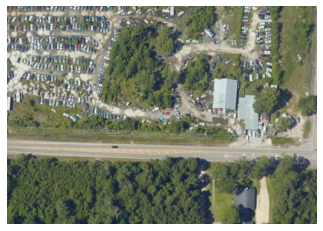

In [192]:
# Select your image by providing the relative path:
img_no_dam3 = PIL.Image.open(f'{path}/no_damage/15006_0.png')
imgplot = plt.imshow(img_no_dam3)
plt.axis("off")

In [193]:
predict_damage(img_no_dam3)

1/1 [==============================] - 0s 18ms/step
Target class percentage probabilities: Damage(0), No_Damage(1)
[[ 1.14 98.86]]


The model predicted that there is no damage on the image and that is correct.

(-0.5, 511.5, 359.5, -0.5)

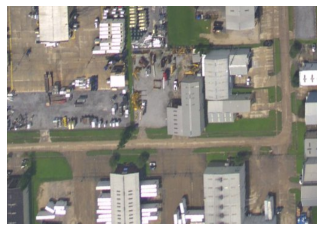

In [202]:
# Select your image by providing the relative path:
img_no_dam4 = PIL.Image.open(f'{path}/no_damage/2009_0.png')
imgplot = plt.imshow(img_no_dam4)
plt.axis("off")

In [203]:
predict_damage(img_no_dam4)

1/1 [==============================] - 0s 18ms/step
Target class percentage probabilities: Damage(0), No_Damage(1)
[[47.72     52.280003]]


The model predicted that there is no damage on the image and that is correct.

(-0.5, 511.5, 359.5, -0.5)

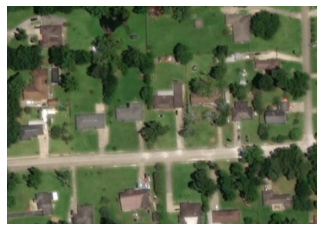

In [204]:
# Select your image by providing the relative path:
img_no_dam5 = PIL.Image.open(f'{path}/no_damage/3005.png')
imgplot = plt.imshow(img_no_dam5)
plt.axis("off")

In [205]:
predict_damage(img_no_dam5)

1/1 [==============================] - 0s 17ms/step
Target class percentage probabilities: Damage(0), No_Damage(1)
[[  0. 100.]]


The model predicted that there is no damage on the image and that is correct.

While testing 10 images, the model made 2 mistakes and that is quite a decent result for our model.

## Conclusions

The CNN model is a powerful tool in image classification which showed high accuracy on the training and validation set as well on the special set from a different source.

Future research will be focused on testing the data from different sources to find and fix the weaknesses of the model through various approaches such as adding new hidden layers in the model, using pre-trained models, expanding the image dataset and others.